# Imports and Functions

In [1]:
import math 
from sklearn.neural_network import MLPClassifier

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model
global threshold
threshold = 20 #300 works
import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 2 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0   

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global ZBranin
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = MLPClassifier(alpha=0.3, max_iter=3000, solver = 'lbfgs')
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    ZBranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        ZBranin.append(braninColor(branincoords[i],20))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', ZBranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist())-1)
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


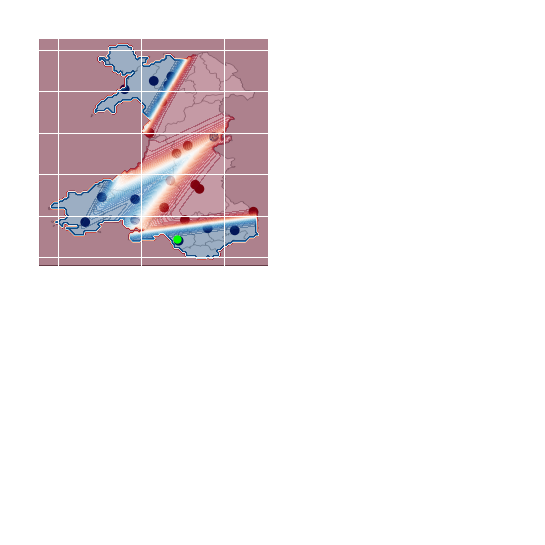

iteration  1
Accuracy is 0.5654681791963084
iteration  2
Accuracy is 0.5608536819842338
iteration  3
Accuracy is 0.5558546433378196
iteration  4
Accuracy is 0.4770236492982119
iteration  5
Accuracy is 0.4218419534704864
iteration  6
Accuracy is 0.4170351855412421
iteration  7
Accuracy is 0.5320130744087676
iteration  8
Accuracy is 0.5029801961161315
iteration  9
Accuracy is 0.535858488752163
iteration  10
Accuracy is 0.5389348202268794
iteration  11
Accuracy is 0.568352239953855
iteration  12
Accuracy is 0.6243030186502596
iteration  13
Accuracy is 0.6048836762161123
iteration  14
Accuracy is 0.5898865602768698
iteration  15
Accuracy is 0.6056527590847914
iteration  16
Accuracy is 0.5862334166506441
iteration  17
Accuracy is 0.6233416650644107
iteration  18
Accuracy is 0.6152662949432801
iteration  19
Accuracy is 0.6400692174581811
iteration  20
Accuracy is 0.6319938473370506
iteration  21
Accuracy is 0.6260334551047876
experiment:  1


<IPython.core.display.Javascript object>


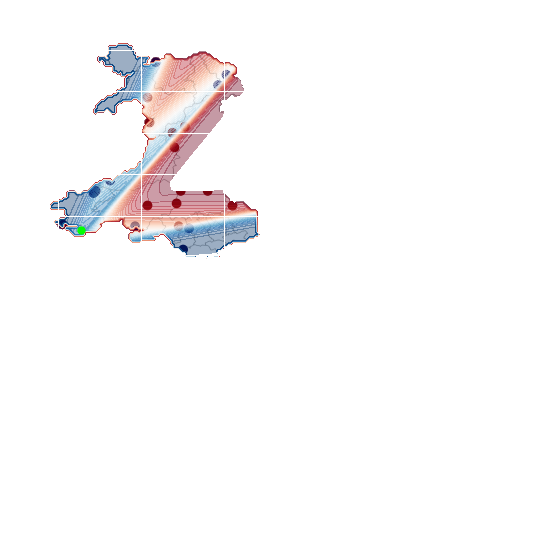

iteration  1
Accuracy is 0.4445298980965199
iteration  2
Accuracy is 0.6771774658719477
iteration  3
Accuracy is 0.6187271678523361
iteration  4
Accuracy is 0.6965968083060949
iteration  5
Accuracy is 0.706018073447414
iteration  6
Accuracy is 0.6990963276293021
iteration  7
Accuracy is 0.6954431840030764
iteration  8
Accuracy is 0.7033262834070371
iteration  9
Accuracy is 0.70082676408383
iteration  10
Accuracy is 0.6591040184579888
iteration  11
Accuracy is 0.6529513555085561
iteration  12
Accuracy is 0.6291097865795039
iteration  13
Accuracy is 0.6539127090944049
iteration  14
Accuracy is 0.6494904825995
iteration  15
Accuracy is 0.551240146125745
iteration  16
Accuracy is 0.58123437800423
iteration  17
Accuracy is 0.5912324552970583
iteration  18
Accuracy is 0.5710440299942319
iteration  19
Accuracy is 0.6783310901749664
iteration  20
Accuracy is 0.6093059027110171
iteration  21
Accuracy is 0.6002691790040376
experiment:  2


<IPython.core.display.Javascript object>


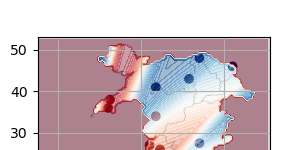

iteration  1
Accuracy is 0.44568352239953857
iteration  2
Accuracy is 0.6965968083060949
iteration  3
Accuracy is 0.588925206691021
iteration  4
Accuracy is 0.5779657758123438
iteration  5
Accuracy is 0.644491443953086
iteration  6
Accuracy is 0.6139203999230917
iteration  7
Accuracy is 0.5687367813881946
iteration  8
Accuracy is 0.5056719861565083
iteration  9
Accuracy is 0.6304556815996923
iteration  10
Accuracy is 0.6408383003268602
iteration  11
Accuracy is 0.6168044606806383
iteration  12
Accuracy is 0.6502595654681792
iteration  13
Accuracy is 0.6466064218419535
iteration  14
Accuracy is 0.6502595654681792
iteration  15
Accuracy is 0.6510286483368583
iteration  16
Accuracy is 0.635839261680446
iteration  17
Accuracy is 0.6185348971351663
iteration  18
Accuracy is 0.704287636992886
iteration  19
Accuracy is 0.7150547971543934
iteration  20
Accuracy is 0.6262257258219573
iteration  21
Accuracy is 0.6216112286098827
experiment:  3


<IPython.core.display.Javascript object>


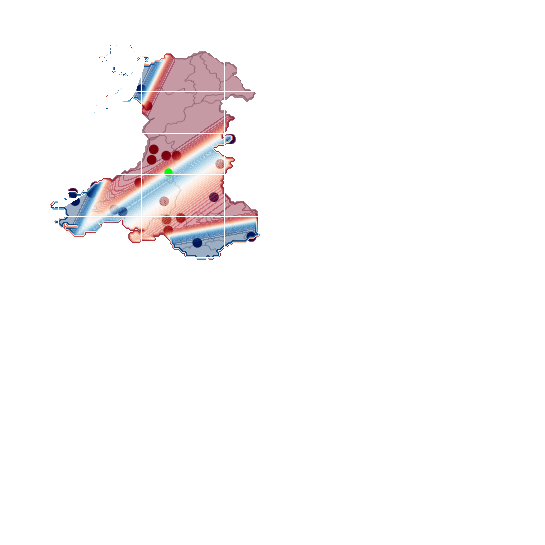

iteration  1
Accuracy is 0.5462411074793309
iteration  2
Accuracy is 0.5925783503172467
iteration  3
Accuracy is 0.6952509132859066
iteration  4
Accuracy is 0.6600653720438378
iteration  5
Accuracy is 0.6592962891751586
iteration  6
Accuracy is 0.6562199577004422
iteration  7
Accuracy is 0.6644875985387425
iteration  8
Accuracy is 0.6516054604883676
iteration  9
Accuracy is 0.6435300903672371
iteration  10
Accuracy is 0.646221880407614
iteration  11
Accuracy is 0.6525668140742165
iteration  12
Accuracy is 0.6466064218419535
iteration  13
Accuracy is 0.6496827533166699
iteration  14
Accuracy is 0.6466064218419535
iteration  15
Accuracy is 0.634108825225918
iteration  16
Accuracy is 0.5662372620649875
iteration  17
Accuracy is 0.5614304941357431
iteration  18
Accuracy is 0.5652759084791387
iteration  19
Accuracy is 0.5425879638531051
iteration  20
Accuracy is 0.564891367044799
iteration  21
Accuracy is 0.5502787925398962
experiment:  4


<IPython.core.display.Javascript object>


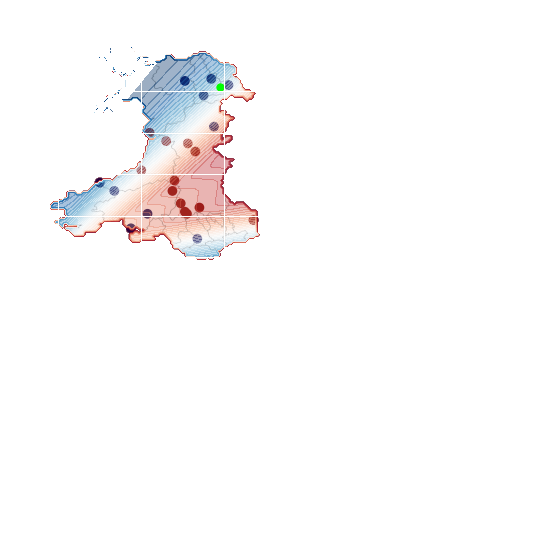

iteration  1
Accuracy is 0.6075754662564892
iteration  2
Accuracy is 0.5998846375696981
iteration  3
Accuracy is 0.6029609690444145
iteration  4
Accuracy is 0.5989232839838493
iteration  5
Accuracy is 0.6150740242261103
iteration  6
Accuracy is 0.5935397039030955
iteration  7
Accuracy is 0.6235339357815805
iteration  8
Accuracy is 0.6804460680638339
iteration  9
Accuracy is 0.681215150932513
iteration  10
Accuracy is 0.6587194770236493
iteration  11
Accuracy is 0.681215150932513
iteration  12
Accuracy is 0.6773697365891175
iteration  13
Accuracy is 0.6696789079023264
iteration  14
Accuracy is 0.6748702172659105
iteration  15
Accuracy is 0.6556431455489329
iteration  16
Accuracy is 0.6442991732359161
iteration  17
Accuracy is 0.6696789079023264
iteration  18
Accuracy is 0.6775620073062872
iteration  19
Accuracy is 0.6883291674677946
iteration  20
Accuracy is 0.6852528359930783
iteration  21
Accuracy is 0.6596808306094982
experiment:  5


<IPython.core.display.Javascript object>


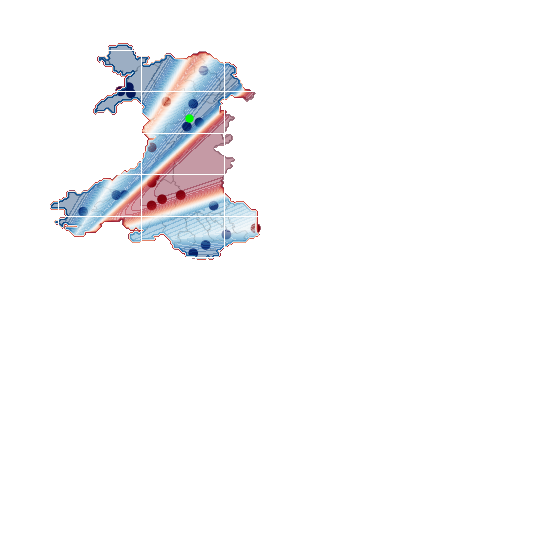

iteration  1
Accuracy is 0.38569505864256876
iteration  2
Accuracy is 0.6004614497212074
iteration  3
Accuracy is 0.550471063257066
iteration  4
Accuracy is 0.416266102672563
iteration  5
Accuracy is 0.5210536435300903
iteration  6
Accuracy is 0.4868294558738704
iteration  7
Accuracy is 0.5898865602768698
iteration  8
Accuracy is 0.5733512786002691
iteration  9
Accuracy is 0.5864256873678139
iteration  10
Accuracy is 0.5868102288021534
iteration  11
Accuracy is 0.5912324552970583
iteration  12
Accuracy is 0.5879638531051721
iteration  13
Accuracy is 0.6104595270140357
iteration  14
Accuracy is 0.6533358969428956
iteration  15
Accuracy is 0.6544895212459142
iteration  16
Accuracy is 0.6569890405691213
iteration  17
Accuracy is 0.6541049798115747
iteration  18
Accuracy is 0.6246875600845991
iteration  19
Accuracy is 0.635839261680446
iteration  20
Accuracy is 0.6675639300134589
iteration  21
Accuracy is 0.662372620649875
experiment:  6


<IPython.core.display.Javascript object>


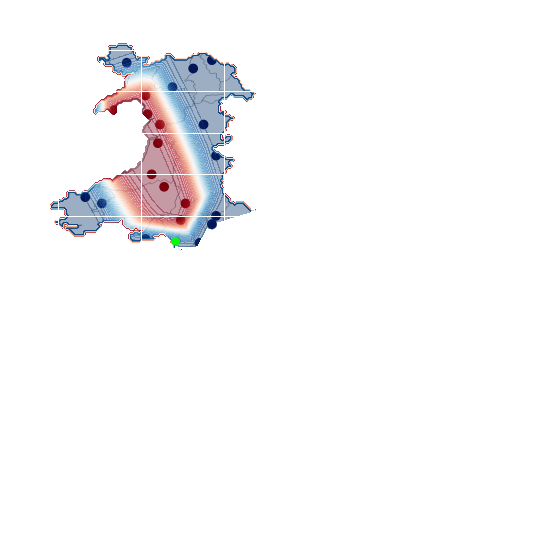

iteration  1
Accuracy is 0.5602768698327245
iteration  2
Accuracy is 0.6664103057104404
iteration  3
Accuracy is 0.6996731397808114
iteration  4
Accuracy is 0.6498750240338397
iteration  5
Accuracy is 0.6556431455489329
iteration  6
Accuracy is 0.6802537973466641
iteration  7
Accuracy is 0.6910209575081715
iteration  8
Accuracy is 0.6416073831955393
iteration  9
Accuracy is 0.6154585656604499
iteration  10
Accuracy is 0.6510286483368583
iteration  11
Accuracy is 0.7117861949625072
iteration  12
Accuracy is 0.622188040761392
iteration  13
Accuracy is 0.6169967313978081
iteration  14
Accuracy is 0.691405498942511
iteration  15
Accuracy is 0.6421841953470486
iteration  16
Accuracy is 0.6152662949432801
iteration  17
Accuracy is 0.6121899634685637
iteration  18
Accuracy is 0.6014228033070563
iteration  19
Accuracy is 0.6119976927513939
iteration  20
Accuracy is 0.5804652951355509
iteration  21
Accuracy is 0.8117669678907903
experiment:  7


<IPython.core.display.Javascript object>


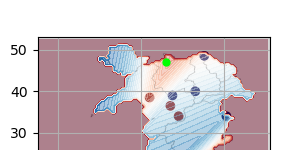

iteration  1
Accuracy is 0.635070178811767
iteration  2
Accuracy is 0.6191117092866757
iteration  3
Accuracy is 0.605075946933282
iteration  4
Accuracy is 0.6273793501249759
iteration  5
Accuracy is 0.642761007498558
iteration  6
Accuracy is 0.6241107479330897
iteration  7
Accuracy is 0.6016150740242261
iteration  8
Accuracy is 0.635070178811767
iteration  9
Accuracy is 0.6521822726398769
iteration  10
Accuracy is 0.6446837146702558
iteration  11
Accuracy is 0.6785233608921362
iteration  12
Accuracy is 0.6694866371851567
iteration  13
Accuracy is 0.6798692559123245
iteration  14
Accuracy is 0.6404537588925207
iteration  15
Accuracy is 0.6514131897711979
iteration  16
Accuracy is 0.5285522014997116
iteration  17
Accuracy is 0.5987310132666794
iteration  18
Accuracy is 0.6094981734281869
iteration  19
Accuracy is 0.608536819842338
iteration  20
Accuracy is 0.6158431070947895
iteration  21
Accuracy is 0.6479523168621419
experiment:  8


<IPython.core.display.Javascript object>


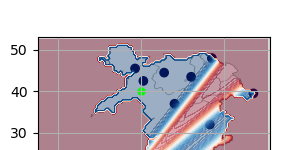

iteration  1
Accuracy is 0.5514324168429148
iteration  2
Accuracy is 0.4758700249951932
iteration  3
Accuracy is 0.4829840415304749
iteration  4
Accuracy is 0.5808498365698904
iteration  5
Accuracy is 0.6210344164583734
iteration  6
Accuracy is 0.62391847721592
iteration  7
Accuracy is 0.6235339357815805
iteration  8
Accuracy is 0.6592962891751586
iteration  9
Accuracy is 0.6560276869832724
iteration  10
Accuracy is 0.6969813497404346
iteration  11
Accuracy is 0.6639107863872332
iteration  12
Accuracy is 0.6583349355893098
iteration  13
Accuracy is 0.6550663333974236
iteration  14
Accuracy is 0.6742934051144011
iteration  15
Accuracy is 0.660642184195347
iteration  16
Accuracy is 0.7021726591040185
iteration  17
Accuracy is 0.7023649298211883
iteration  18
Accuracy is 0.7046721784272255
iteration  19
Accuracy is 0.671793885791194
iteration  20
Accuracy is 0.6664103057104404
iteration  21
Accuracy is 0.6514131897711979
experiment:  9


<IPython.core.display.Javascript object>


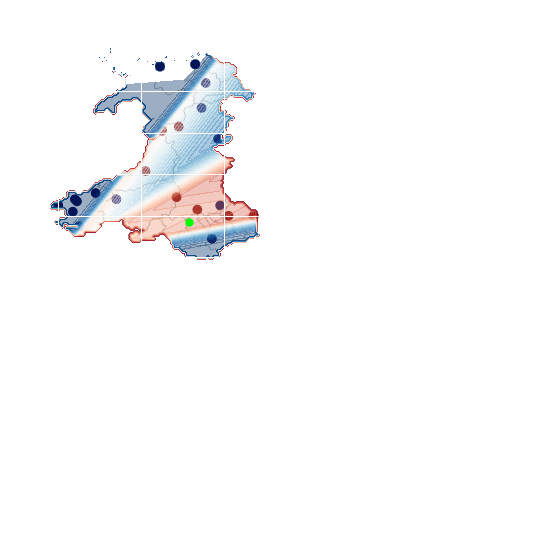

iteration  1
Accuracy is 0.5943087867717747
iteration  2
Accuracy is 0.6139203999230917
iteration  3
Accuracy is 0.6133435877715824
iteration  4
Accuracy is 0.5875793116708325
iteration  5
Accuracy is 0.5864256873678139
iteration  6
Accuracy is 0.5866179580849836
iteration  7
Accuracy is 0.5808498365698904
iteration  8
Accuracy is 0.5639300134589502
iteration  9
Accuracy is 0.5750817150547971
iteration  10
Accuracy is 0.6087290905595077
iteration  11
Accuracy is 0.6089213612766775
iteration  12
Accuracy is 0.6366083445491252
iteration  13
Accuracy is 0.6381465102864834
iteration  14
Accuracy is 0.6279561622764853
iteration  15
Accuracy is 0.6383387810036532
iteration  16
Accuracy is 0.6356469909632763
iteration  17
Accuracy is 0.5796962122668717
iteration  18
Accuracy is 0.6910209575081715
iteration  19
Accuracy is 0.6498750240338397
iteration  20
Accuracy is 0.6650644106902519
iteration  21
Accuracy is 0.6685252835993079
experiment:  10


<IPython.core.display.Javascript object>


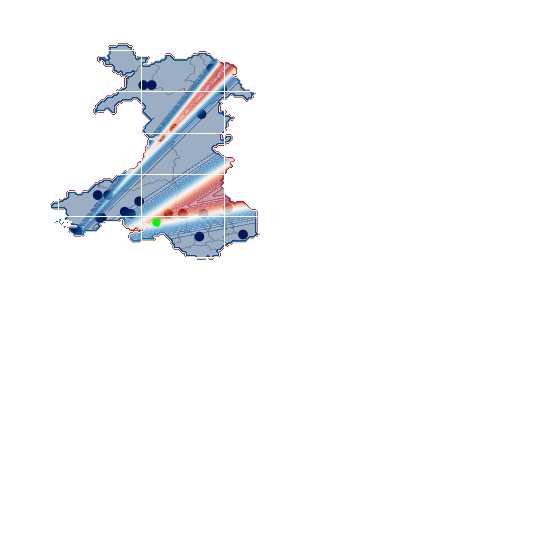

iteration  1
Accuracy is 0.5616227648529128
iteration  2
Accuracy is 0.5158623341665064
iteration  3
Accuracy is 0.5491251682368775
iteration  4
Accuracy is 0.5497019803883868
iteration  5
Accuracy is 0.5550855604691406
iteration  6
Accuracy is 0.5783503172466833
iteration  7
Accuracy is 0.5837338973274371
iteration  8
Accuracy is 0.642761007498558
iteration  9
Accuracy is 0.6525668140742165
iteration  10
Accuracy is 0.6569890405691213
iteration  11
Accuracy is 0.6514131897711979
iteration  12
Accuracy is 0.6498750240338397
iteration  13
Accuracy is 0.6512209190540281
iteration  14
Accuracy is 0.6516054604883676
iteration  15
Accuracy is 0.6525668140742165
iteration  16
Accuracy is 0.6464141511247837
iteration  17
Accuracy is 0.6150740242261103
iteration  18
Accuracy is 0.6273793501249759
iteration  19
Accuracy is 0.62391847721592
iteration  20
Accuracy is 0.6146894827917708
iteration  21
Accuracy is 0.6506441069025187
experiment:  11


<IPython.core.display.Javascript object>


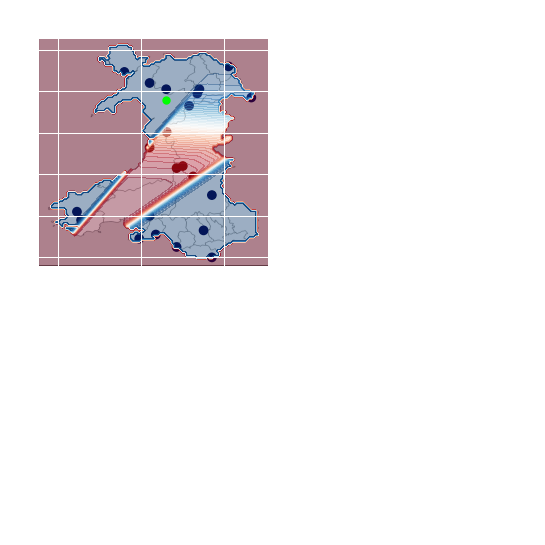

iteration  1
Accuracy is 0.4862526437223611
iteration  2
Accuracy is 0.5402807152470679
iteration  3
Accuracy is 0.5445106710248029
iteration  4
Accuracy is 0.5581618919438569
iteration  5
Accuracy is 0.5610459527014036
iteration  6
Accuracy is 0.5668140742164969
iteration  7
Accuracy is 0.5577773505095174
iteration  8
Accuracy is 0.577773505095174
iteration  9
Accuracy is 0.5910401845798885
iteration  10
Accuracy is 0.6250721015189387
iteration  11
Accuracy is 0.6458373389732743
iteration  12
Accuracy is 0.6208421457412037
iteration  13
Accuracy is 0.6243030186502596
iteration  14
Accuracy is 0.6481445875793117
iteration  15
Accuracy is 0.6627571620842145
iteration  16
Accuracy is 0.6604499134781773
iteration  17
Accuracy is 0.6629494328013843
iteration  18
Accuracy is 0.6619880792155355
iteration  19
Accuracy is 0.6483368582964815
iteration  20
Accuracy is 0.6410305710440299
iteration  21
Accuracy is 0.6481445875793117
experiment:  12


<IPython.core.display.Javascript object>


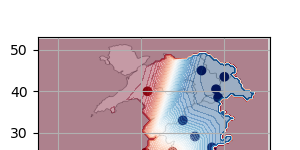

iteration  1
Accuracy is 0.3899250144203038
iteration  2
Accuracy is 0.3699288598346472
iteration  3
Accuracy is 0.39415497019803886
iteration  4
Accuracy is 0.5585464333781965
iteration  5
Accuracy is 0.6071909248221495
iteration  6
Accuracy is 0.5893097481253605
iteration  7
Accuracy is 0.5839261680446068
iteration  8
Accuracy is 0.6379542395693136
iteration  9
Accuracy is 0.6383387810036532
iteration  10
Accuracy is 0.6019996154585656
iteration  11
Accuracy is 0.6281484329936551
iteration  12
Accuracy is 0.6185348971351663
iteration  13
Accuracy is 0.676023841568929
iteration  14
Accuracy is 0.6956354547202461
iteration  15
Accuracy is 0.6798692559123245
iteration  16
Accuracy is 0.5545087483176312
iteration  17
Accuracy is 0.560661411267064
iteration  18
Accuracy is 0.5650836377619689
iteration  19
Accuracy is 0.5633532013074409
iteration  20
Accuracy is 0.5445106710248029
iteration  21
Accuracy is 0.716208421457412
experiment:  13


<IPython.core.display.Javascript object>


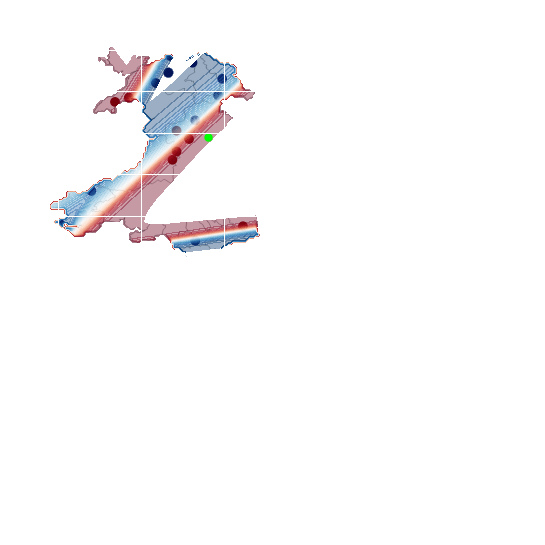

iteration  1
Accuracy is 0.5229763507017882
iteration  2
Accuracy is 0.522207267833109
iteration  3
Accuracy is 0.5831570851759277
iteration  4
Accuracy is 0.6246875600845991
iteration  5
Accuracy is 0.6131513170544126
iteration  6
Accuracy is 0.6371851567006345
iteration  7
Accuracy is 0.6483368582964815
iteration  8
Accuracy is 0.625648913670448
iteration  9
Accuracy is 0.6723706979427033
iteration  10
Accuracy is 0.816189194385695
iteration  11
Accuracy is 0.6664103057104404
iteration  12
Accuracy is 0.6502595654681792
iteration  13
Accuracy is 0.6300711401653528
iteration  14
Accuracy is 0.644491443953086
iteration  15
Accuracy is 0.646990963276293
iteration  16
Accuracy is 0.6414151124783696
iteration  17
Accuracy is 0.6412228417611998
iteration  18
Accuracy is 0.635839261680446
iteration  19
Accuracy is 0.6062295712363007
iteration  20
Accuracy is 0.6206498750240338
iteration  21
Accuracy is 0.6002691790040376
experiment:  14


<IPython.core.display.Javascript object>


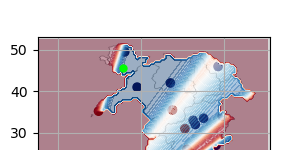

iteration  1
Accuracy is 0.42241876562199576
iteration  2
Accuracy is 0.5893097481253605
iteration  3
Accuracy is 0.41165160546048835
iteration  4
Accuracy is 0.5681599692366852
iteration  5
Accuracy is 0.5810421072870602
iteration  6
Accuracy is 0.566621803499327
iteration  7
Accuracy is 0.4633724283791579
iteration  8
Accuracy is 0.5335512401461258
iteration  9
Accuracy is 0.5231686214189579
iteration  10
Accuracy is 0.5668140742164969
iteration  11
Accuracy is 0.516246875600846
iteration  12
Accuracy is 0.5616227648529128
iteration  13
Accuracy is 0.5429725052874447
iteration  14
Accuracy is 0.5420111517015959
iteration  15
Accuracy is 0.5754662564891367
iteration  16
Accuracy is 0.6035377811959238
iteration  17
Accuracy is 0.5823880023072486
iteration  18
Accuracy is 0.5937319746202653
iteration  19
Accuracy is 0.5823880023072486
iteration  20
Accuracy is 0.5875793116708325
iteration  21
Accuracy is 0.5739280907517785
experiment:  15


<IPython.core.display.Javascript object>


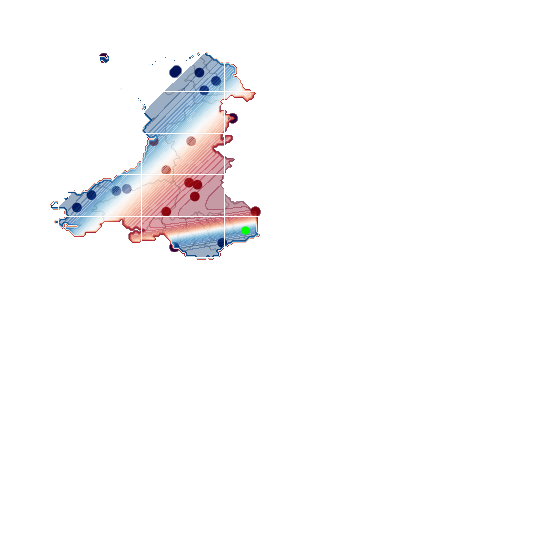

iteration  1
Accuracy is 0.6414151124783696
iteration  2
Accuracy is 0.6446837146702558
iteration  3
Accuracy is 0.6439146318015766
iteration  4
Accuracy is 0.6098827148625264
iteration  5
Accuracy is 0.6064218419534705
iteration  6
Accuracy is 0.6098827148625264
iteration  7
Accuracy is 0.6058450298019612
iteration  8
Accuracy is 0.6106517977312056
iteration  9
Accuracy is 0.5864256873678139
iteration  10
Accuracy is 0.5754662564891367
iteration  11
Accuracy is 0.6556431455489329
iteration  12
Accuracy is 0.6667948471447799
iteration  13
Accuracy is 0.6612189963468563
iteration  14
Accuracy is 0.6939050182657182
iteration  15
Accuracy is 0.6910209575081715
iteration  16
Accuracy is 0.6839069409728898
iteration  17
Accuracy is 0.6664103057104404
iteration  18
Accuracy is 0.6814074216496827
iteration  19
Accuracy is 0.6879446260334551
iteration  20
Accuracy is 0.6844837531243991
iteration  21
Accuracy is 0.6892905210536435
experiment:  16


<IPython.core.display.Javascript object>


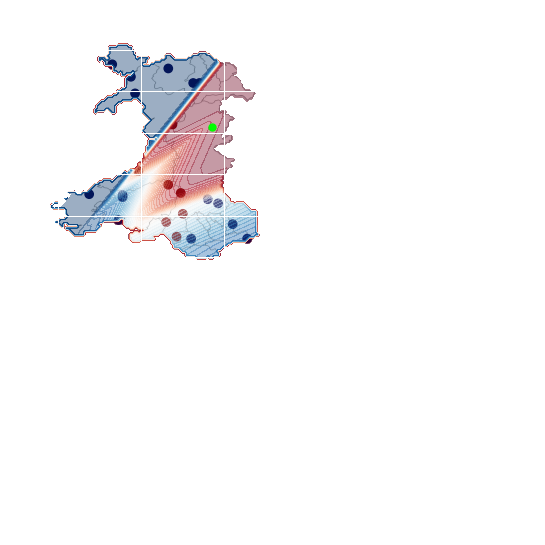

iteration  1
Accuracy is 0.500865218227264
iteration  2
Accuracy is 0.4987502403383965
iteration  3
Accuracy is 0.4979811574697174
iteration  4
Accuracy is 0.5731590078830994
iteration  5
Accuracy is 0.5395116323783887
iteration  6
Accuracy is 0.5483560853681985
iteration  7
Accuracy is 0.637569698134974
iteration  8
Accuracy is 0.6827533166698712
iteration  9
Accuracy is 0.710248029225149
iteration  10
Accuracy is 0.704287636992886
iteration  11
Accuracy is 0.6506441069025187
iteration  12
Accuracy is 0.6939050182657182
iteration  13
Accuracy is 0.6831378581042107
iteration  14
Accuracy is 0.631609305902711
iteration  15
Accuracy is 0.6862141895789271
iteration  16
Accuracy is 0.6600653720438378
iteration  17
Accuracy is 0.6935204768313786
iteration  18
Accuracy is 0.7017881176696789
iteration  19
Accuracy is 0.6958277254374159
iteration  20
Accuracy is 0.6823687752355316
iteration  21
Accuracy is 0.6691020957508171
experiment:  17


<IPython.core.display.Javascript object>


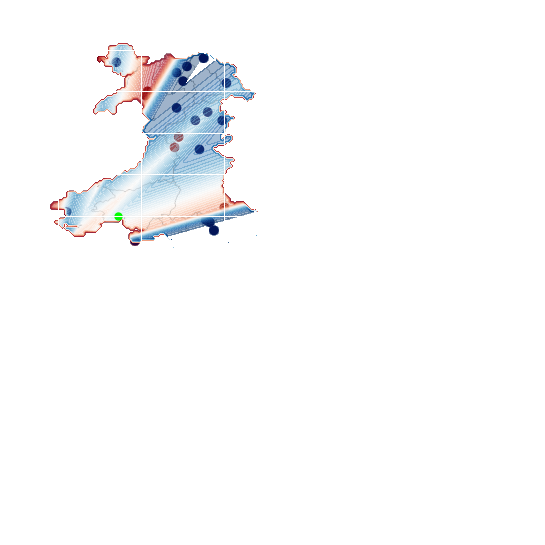

iteration  1
Accuracy is 0.5468179196308403
iteration  2
Accuracy is 0.5796962122668717
iteration  3
Accuracy is 0.58123437800423
iteration  4
Accuracy is 0.58123437800423
iteration  5
Accuracy is 0.58123437800423
iteration  6
Accuracy is 0.58123437800423
iteration  7
Accuracy is 0.5846952509132859
iteration  8
Accuracy is 0.545279753893482
iteration  9
Accuracy is 0.566621803499327
iteration  10
Accuracy is 0.5408575273985772
iteration  11
Accuracy is 0.5575850797923476
iteration  12
Accuracy is 0.5539319361661219
iteration  13
Accuracy is 0.545279753893482
iteration  14
Accuracy is 0.5687367813881946
iteration  15
Accuracy is 0.5598923283983849
iteration  16
Accuracy is 0.5604691405498943
iteration  17
Accuracy is 0.5731590078830994
iteration  18
Accuracy is 0.5472024610651798
iteration  19
Accuracy is 0.5660449913478177
iteration  20
Accuracy is 0.5748894443376273
iteration  21
Accuracy is 0.5608536819842338
experiment:  18


<IPython.core.display.Javascript object>


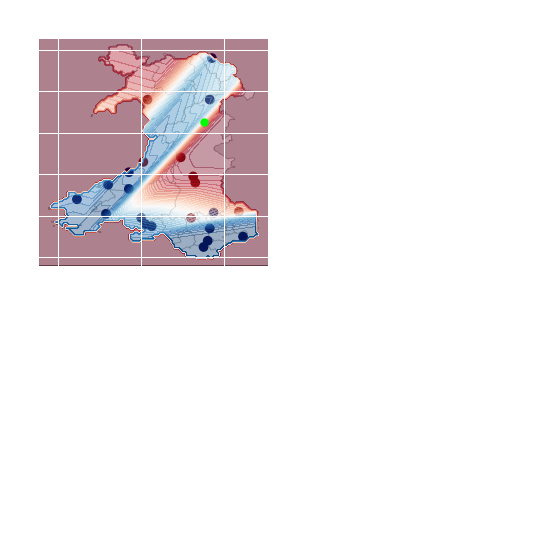

iteration  1
Accuracy is 0.39319361661219
iteration  2
Accuracy is 0.6106517977312056
iteration  3
Accuracy is 0.6198807921553547
iteration  4
Accuracy is 0.6087290905595077
iteration  5
Accuracy is 0.6546817919630841
iteration  6
Accuracy is 0.43856950586425686
iteration  7
Accuracy is 0.4868294558738704
iteration  8
Accuracy is 0.4310709478946356
iteration  9
Accuracy is 0.4422226494904826
iteration  10
Accuracy is 0.43645452797538936
iteration  11
Accuracy is 0.4229955777735051
iteration  12
Accuracy is 0.43741588156123823
iteration  13
Accuracy is 0.48971351663141705
iteration  14
Accuracy is 0.5216304556815997
iteration  15
Accuracy is 0.5143241684291482
iteration  16
Accuracy is 0.5514324168429148
iteration  17
Accuracy is 0.566621803499327
iteration  18
Accuracy is 0.5733512786002691
iteration  19
Accuracy is 0.5804652951355509
iteration  20
Accuracy is 0.5731590078830994
iteration  21
Accuracy is 0.6139203999230917
experiment:  19


<IPython.core.display.Javascript object>


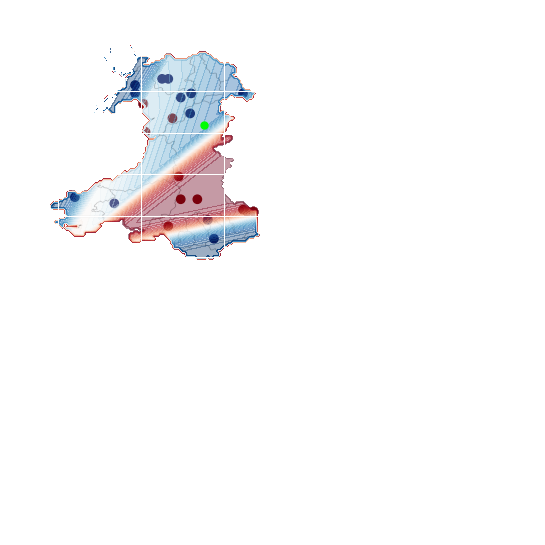

iteration  1
Accuracy is 0.44049221303595465
iteration  2
Accuracy is 0.4843299365506633
iteration  3
Accuracy is 0.5779657758123438
iteration  4
Accuracy is 0.5771966929436647
iteration  5
Accuracy is 0.5829648144587579
iteration  6
Accuracy is 0.6137281292059219
iteration  7
Accuracy is 0.5737358200346088
iteration  8
Accuracy is 0.5771966929436647
iteration  9
Accuracy is 0.5793116708325322
iteration  10
Accuracy is 0.5771966929436647
iteration  11
Accuracy is 0.6262257258219573
iteration  12
Accuracy is 0.642761007498558
iteration  13
Accuracy is 0.6712170736396846
iteration  14
Accuracy is 0.6727552393770428
iteration  15
Accuracy is 0.6848682945587387
iteration  16
Accuracy is 0.6844837531243991
iteration  17
Accuracy is 0.676985195154778
iteration  18
Accuracy is 0.6915977696596808
iteration  19
Accuracy is 0.6596808306094982
iteration  20
Accuracy is 0.6791001730436454
iteration  21
Accuracy is 0.6887137089021342
experiment:  20


<IPython.core.display.Javascript object>


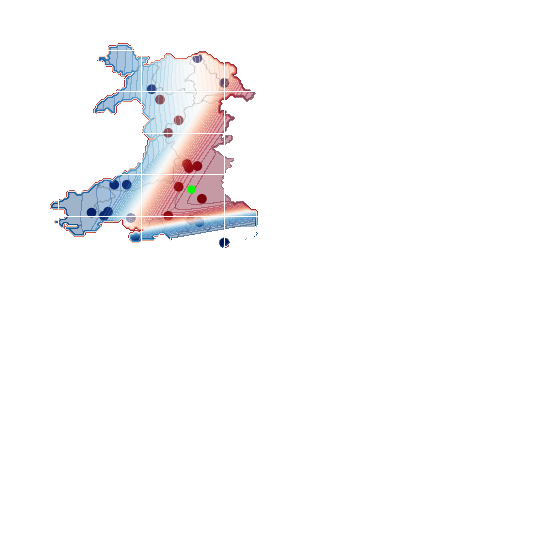

iteration  1
Accuracy is 0.5654681791963084
iteration  2
Accuracy is 0.5241299750048067
iteration  3
Accuracy is 0.49452028456066144
iteration  4
Accuracy is 0.5437415881561238
iteration  5
Accuracy is 0.5510478754085752
iteration  6
Accuracy is 0.545279753893482
iteration  7
Accuracy is 0.5970005768121515
iteration  8
Accuracy is 0.602576427610075
iteration  9
Accuracy is 0.6194962507210152
iteration  10
Accuracy is 0.6254566429532782
iteration  11
Accuracy is 0.6352624495289367
iteration  12
Accuracy is 0.6262257258219573
iteration  13
Accuracy is 0.6815996923668526
iteration  14
Accuracy is 0.6881368967506248
iteration  15
Accuracy is 0.6054604883676216
iteration  16
Accuracy is 0.6396846760238416
iteration  17
Accuracy is 0.6279561622764853
iteration  18
Accuracy is 0.6119976927513939
iteration  19
Accuracy is 0.6352624495289367
iteration  20
Accuracy is 0.6004614497212074
iteration  21
Accuracy is 0.6168044606806383


In [7]:
from random import randint
import time

valid_seeds = [4,27,12,15,17,21,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 68.81 %
Improvement is = 12.27 %


In [9]:
Results

[[0.5654681791963084,
  0.5608536819842338,
  0.5558546433378196,
  0.4770236492982119,
  0.4218419534704864,
  0.4170351855412421,
  0.5320130744087676,
  0.5029801961161315,
  0.535858488752163,
  0.5389348202268794,
  0.568352239953855,
  0.6243030186502596,
  0.6048836762161123,
  0.5898865602768698,
  0.6056527590847914,
  0.5862334166506441,
  0.6233416650644107,
  0.6152662949432801,
  0.6400692174581811,
  0.6319938473370506,
  0.6260334551047876],
 [0.4445298980965199,
  0.6771774658719477,
  0.6187271678523361,
  0.6965968083060949,
  0.706018073447414,
  0.6990963276293021,
  0.6954431840030764,
  0.7033262834070371,
  0.70082676408383,
  0.6591040184579888,
  0.6529513555085561,
  0.6291097865795039,
  0.6539127090944049,
  0.6494904825995,
  0.551240146125745,
  0.58123437800423,
  0.5912324552970583,
  0.5710440299942319,
  0.6783310901749664,
  0.6093059027110171,
  0.6002691790040376],
 [0.44568352239953857,
  0.6965968083060949,
  0.588925206691021,
  0.577965775812343

In [12]:
np.savetxt('BraninRandomnn', Results)

In [11]:
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns

# define a and b here
a = tst
b = []
for i in range(21):
    b.append(i+1)

# Helps pick a random color for each plot, used for readability
rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
ax.set(ylim=(0.4, 1))

for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr, alpha = 0.2)
    sns.boxplot(data=tst)

NameError: name 'tst' is not defined

In [ ]:
tst = np.loadtxt('BraninRandom')